In [1]:
# SEP769 - July 27, 2021
# Amir Kamaleddine, Ernani Fantinatti, Mohammed Ibraheem
# CNN model for classifying normal and imbalanced motors as part of the MAFAULDA motor fault dataset
# If training, we suggest you use GPU acceleration in Colab
# https://github.com/efantinatti/MAFAULDA_SEP769


In [2]:
# Load in tensorboard extension to view results interactively
%load_ext tensorboard


In [3]:
# Load relevant libraries
import numpy as np
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv1D
import matplotlib.pyplot as plt
import glob
import datetime

In [4]:
# Decide whether to load model from a .h5 file or train a new one
# 0 if training the model again
# 1 if loading model
saved_model = 0


In [5]:
# Loads train/test data from .txt files to np arrays 
# Ensure you choose the correct file directory

dir = 'C:/Users/KOMPUTER/Documents/Jupyter Notebooks/MAFAULDA_SEP769-main/Models/content/jul27data/'

train_reload = np.loadtxt(dir + 'train_data.txt')
test_reload = np.loadtxt(dir + 'test_data.txt')

print("Loaded data files...")


Loaded data files...


In [6]:
# Shaping the training/testing data
# Shapes the data into an nx500x8 array
# Each sequence is 500 timesteps (10 ms of data collection)

train_data = np.reshape(train_reload,(-1,500, 8))
test_data = np.reshape(test_reload,(-1,500, 8))


In [7]:
# Loads labels corresponding to training/test data
train_label = np.loadtxt(dir + 'train_label.txt').astype(int)
test_label = np.loadtxt(dir + 'test_label.txt').astype(int)


In [8]:
# Build the model
# Sequential model
model = Sequential()

# Conv1D is used to perform convolution on temporal data
model.add(Conv1D(30, (5), input_shape=(500, 8), padding = 'same', strides = 1, activation='relu'))

# Flatten before feeding into dense layers
model.add(Flatten())

# Dense layers and Output Layer
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile model
# Binary crossentropy for a binary classifier
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 500, 30)           1230      
_________________________________________________________________
flatten (Flatten)            (None, 15000)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                480032    
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 481,807
Trainable params: 481,807
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Log model training process with Tensorboard
ld = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
callTensorboard = tf.keras.callbacks.TensorBoard(log_dir=ld, histogram_freq=1)


In [10]:
if saved_model == 0:
    # Train model
    # Note that validation data is NOT used to train model at all
    history = model.fit(train_data, train_label, validation_data=(test_data, test_label), callbacks = [callTensorboard], epochs=50, batch_size=32)
    model.save('C:/Users/KOMPUTER/Documents/Jupyter Notebooks/MAFAULDA_SEP769-main/Models/CNN.h5')
else:
    # Load model from .h5 file
    model = load_model('C:/Users/KOMPUTER/Documents/Jupyter Notebooks/MAFAULDA_SEP769-main/Models/CNN.h5')


Epoch 1/50
  1/156 [..............................] - ETA: 0s - loss: 0.6396 - accuracy: 0.7500WARNING:tensorflow:From C:\Users\KOMPUTER\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
156/156 [==============================] - 3s 21ms/step - loss: 0.2554 - accuracy: 0.8964 - val_loss: 0.1915 - val_accuracy: 0.9588
Epoch 2/50
156/156 [==============================] - 2s 13ms/step - loss: 0.1064 - accuracy: 0.9643 - val_loss: 0.1574 - val_accuracy: 0.9588
Epoch 3/50
156/156 [==============================] - 2s 14ms/step - loss: 0.0555 - accuracy: 0.9864 - val_loss: 0.1119 - val_accuracy: 0.9802
Epoch 4/50
156/156 [==============================] - 2s 15ms/step - loss: 0.0408 - accuracy: 0.9896 - val_loss: 0.0727 - val_accuracy: 0.9751
Epoch 5/50
156/156 [==============================] - 2s 13

In [11]:
# Evaluate model performance with test set
score = model.evaluate(train_data, train_label, verbose=0)
print("Training Accuracy: ", score[1])
score = model.evaluate(test_data, test_label, verbose=0)
print("Test Accuracy: ", score[1])

Training Accuracy:  1.0
Test Accuracy:  0.9858757257461548


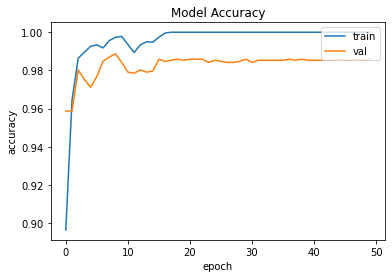

In [12]:
# Plot model accuracy over epoch if trained
#If you have chosen 'saved_model == 1', chart won't be presented.
if saved_model == 0:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()


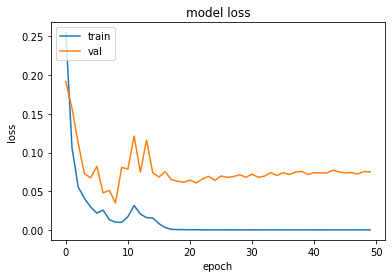

In [13]:
if saved_model == 0:
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [14]:
preds = model.predict(test_data) # label scores 

classpreds = np.argmax(preds, axis=0) # predicted classes 

y_testclass = np.argmax(test_label, axis=0) # true classes

n_classes=2 # number of classes

In [18]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Confusion Matrix
c_names = ['normal', 'unbalance']
cm = confusion_matrix(y_testclass, classpreds)
print(cm)

# Get percentage value for each element of the matrix
cm_sum = np.sum(cm, axis=1, keepdims=True)
cm_perc = cm / cm_sum.astype(float) * 100
annot = np.empty_like(cm).astype(str)
nrows, ncols = cm.shape
for i in range(nrows):
    for j in range(ncols):
        c = cm[i, j]
        p = cm_perc[i, j]
        if i == j:
            s = cm_sum[i]
            annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
        elif c == 0:
            annot[i, j] = ''
        else:
            annot[i, j] = '%.1f%%\n%d' % (p, c)

# Display confusion matrix 
df_cm = pd.DataFrame(cm, index = c_names, columns = c_names)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(df_cm, annot=annot, fmt='')

TypeError: Singleton array 910 cannot be considered a valid collection.

In [17]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_testclass, classpreds)
print('Confusion Matrix\n')
print(confusion)

#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_testclass, classpreds)))

print('Micro Precision: {:.2f}'.format(precision_score(y_testclass, classpreds, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_testclass, classpreds, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_testclass, classpreds, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_testclass, classpreds, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_testclass, classpreds, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_testclass, classpreds, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_testclass, classpreds, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_testclass, classpreds, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_testclass, classpreds, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_testclass, classpreds, target_names=['normal', 'unbalance']))

TypeError: Singleton array 910 cannot be considered a valid collection.

In [ ]:
#If you have chosen 'saved_model == 1', Tensorboard won't work.
%tensorboard --logdir logs/fit
